Importo todas las librerías necesarias para el notebook.

In [15]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
import tensorflow_decision_forests as tfdf

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns
import sys, os, warnings, logging
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
from IPython.display import clear_output
import random

Ahora fijo una semilla para que todas las ejecuciones del notebook sean iguales

In [16]:
seed = 2024

# Establecer la semilla para la generación de números aleatorios en Python
random.seed(seed)

# Establecer la semilla para numpy
np.random.seed(seed)

# Establecer la semilla para tensorflow
tf.random.set_seed(seed)

Esta clase permite omitir parte de la salida innecesaria de los modelos, que sobrecargan la salida con información que no nos sirve

In [17]:
class SuppressPrints:
    def __enter__(self):
        # Guardar los flujos originales
        self._stdout = sys.stdout
        self._stderr = sys.stderr
        self._warnings_showwarning = warnings.showwarning
        self._logging_level = logging.getLogger().level

        # Redirigir stdout y stderr a /dev/null
        sys.stdout = open(os.devnull, 'w')
        sys.stderr = open(os.devnull, 'w')
        
        # Suprimir warnings
        warnings.showwarning = self._suppress_warnings
        
        # Suprimir logging
        logging.getLogger().setLevel(logging.CRITICAL)

    def __exit__(self, exc_type, exc_val, exc_tb):
        # Restaurar los flujos originales
        sys.stdout.close()
        sys.stderr.close()
        sys.stdout = self._stdout
        sys.stderr = self._stderr
        
        # Restaurar el manejo de warnings
        warnings.showwarning = self._warnings_showwarning
        
        # Restaurar el nivel de logging
        logging.getLogger().setLevel(self._logging_level)

    def _suppress_warnings(self, *args, **kwargs):
        pass

# Importo los datos

In [18]:
data = pd.read_csv("Occupancy.csv")
# Elimino el timestamp porque no me interesa usar esta información
data = data.drop(columns=["date"])
data

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
0,23.7000,26.2720,585.200000,749.200000,0.004764,1
1,23.7180,26.2900,578.400000,760.400000,0.004773,1
2,23.7300,26.2300,572.666667,769.666667,0.004765,1
3,23.7225,26.1250,493.750000,774.750000,0.004744,1
4,23.7540,26.2000,488.600000,779.000000,0.004767,1
...,...,...,...,...,...,...
20555,20.8150,27.7175,429.750000,1505.250000,0.004213,1
20556,20.8650,27.7450,423.500000,1514.500000,0.004230,1
20557,20.8900,27.7450,423.500000,1521.500000,0.004237,1
20558,20.8900,28.0225,418.750000,1632.000000,0.004279,1


Divido los datos en X e y y los divido en entrenamiento, validación y testeo

In [19]:

# Dividir los datos en características (X) y etiquetas (y)
X = data.drop(columns=["Occupancy"])
y = data["Occupancy"]

# Dividir los datos en conjuntos de entrenamiento, validación y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Imprimir las formas de los conjuntos de datos resultantes
print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_val:", y_val.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train: (12336, 5)
Forma de X_val: (4112, 5)
Forma de X_test: (4112, 5)
Forma de y_train: (12336,)
Forma de y_val: (4112,)
Forma de y_test: (4112,)


# Exploro los datos de entrenamiento

In [20]:
y_train == 0

17053    True
537      True
12767    True
3005     True
6759     True
         ... 
12668    True
15863    True
9929     True
8769     True
10015    True
Name: Occupancy, Length: 12336, dtype: bool

Utilizo matplotlib sobre los datos de entrenamiento para ver la distribución de cada variable para los casos positivos y los negativos.

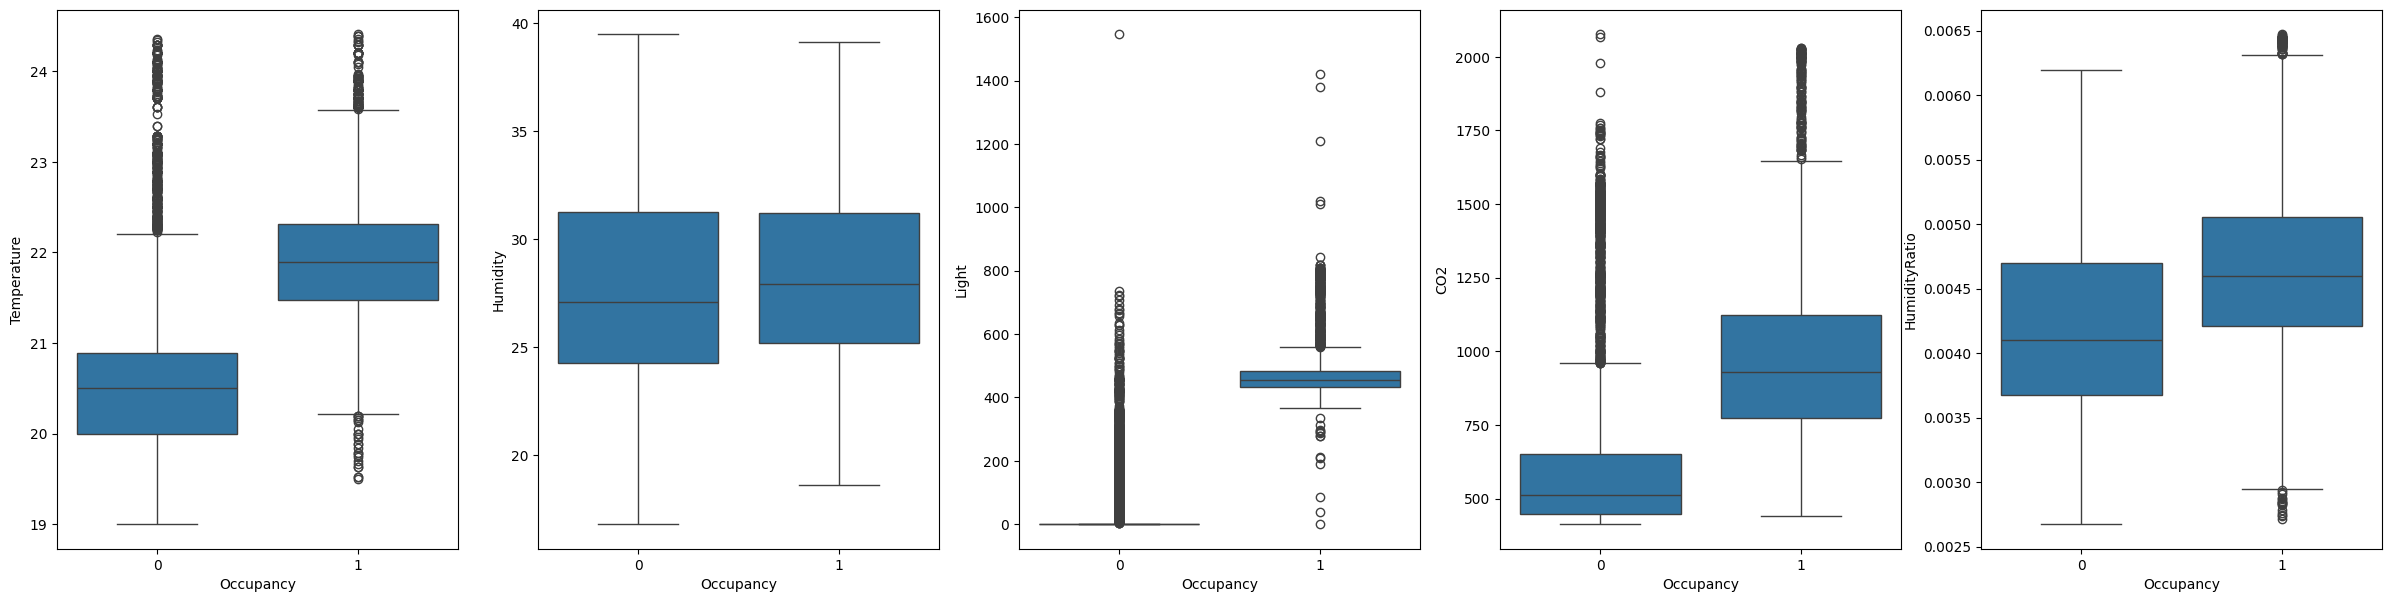

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [21]:


# Create boxplots for each column of X, discriminating by the variable y
fig, axs = plt.subplots(1, 5, figsize=(30, 7))
for (column,ax) in zip(X_train.columns,axs):
    plt.figure()
    sns.boxplot(x=y_train, y=X_train[column], ax=ax)
    # ax.set_xlabel("Occupancy")
    # ax.set_ylabel(column)
clear_output()
plt.show()

De cada variable se observa:
* Temperatura: Parece que está más calido en los momentos en los que hay gente.
* La humedad no muestra grandes diferencias
* La luz tiene distribuciones completamente distintas en ambos casos. Hay mucha más gente en los momentos que hay luz.
* El CO2 también tiene una aparente correlación positiva con la presencia de personas.
* El ratio de humedad tampoco muestra diferencias tna grandes, aunque más notorias que en el nivel absoluto de humedad.

El problema que puede haber es que varios de estos factores en vez de ser consecuencia y algo que permita detectar si hay personas, sean en realidad una causa de que la gente asista o una consecuencia de una causa de que la gente asista, por ejemplo de la hora (hay más calor y luz de día que de noche).

# Aplicamos modelos predictivos y los comparamos

El primer modelo que vamos a entrenar con los datos es una simple regresión logistica.

In [22]:
# Define the logistic regression model
class LogisticRegression(tf.keras.Model):
    def __init__(self, num_features):
        super(LogisticRegression, self).__init__()
        self.dense = tf.keras.layers.Dense(1, activation='sigmoid', input_shape=(num_features,))
        
    def call(self, inputs):
        return self.dense(inputs)

# Create an instance of the logistic regression model
num_features = X_train.shape[1]
model = LogisticRegression(num_features)

# Define the loss function and optimizer
loss_fn = tf.keras.losses.BinaryCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

# Compile the model
model.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

# Train the model
batch_size = [32, 64, 128, 256, 512, len(X_train)]
epochs = [10, 10, 10, 10, 10, 100]
history = model.fit(X_train, y_train, batch_size=batch_size[0], epochs=epochs[0], validation_data=(X_val, y_val))

for b_s, ep in zip(batch_size[1:], epochs[1:]):
    history_2 = model.fit(X_train, y_train, batch_size=b_s, epochs=ep, validation_data=(X_val, y_val))
    for key in history.history.keys():
        history.history[key] += history_2.history[key]
        
# Evaluate the model on the test set
y_pred = model.predict(X_val)
y_pred = (y_val > 0.5).astype(int)
accuracy = accuracy_score(y_val, y_pred)
clear_output()

En los siguientes gráficos podemos ver cómo mejoran las metricas (perdida y precisión) sobre los datos (de entrenamiento y de validación) a lo largo de las iteraciones.

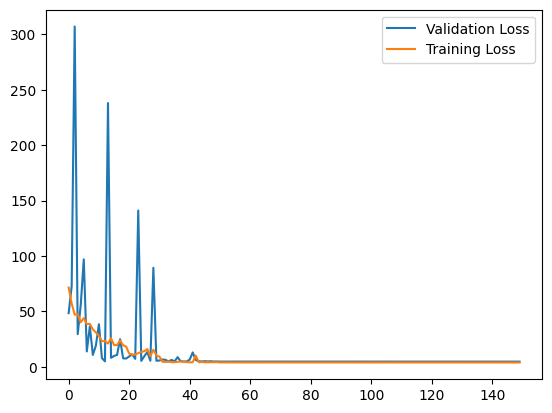

In [23]:
history_2 = history.history
plt.plot(
    list(zip(history_2["val_loss"],history_2["loss"])),
    label = ["Validation Loss", "Training Loss"]
)
plt.legend()
plt.show()

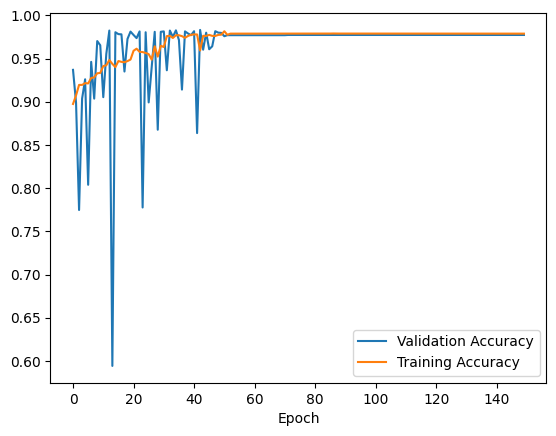

In [24]:
plt.plot(
    list(zip(history_2["val_accuracy"],history_2["accuracy"])),
    label = ["Validation Accuracy", "Training Accuracy"]
)
plt.xlabel("Epoch")
plt.legend()
plt.show()

Una vista rápida del formato de los datos

In [25]:
pd.concat([X_train, y_train], axis=1)

,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
17053,20.290000,30.600,0.00,721.333333,0.004505,0
537,20.700000,22.330,0.00,454.600000,0.003366,0
12767,21.000000,26.495,0.00,568.500000,0.004072,0
3005,21.200000,25.390,0.00,467.000000,0.003950,0
6759,22.600000,17.175,163.25,443.750000,0.002905,0
...,...,...,...,...,...,...
12668,21.100000,27.090,0.00,567.000000,0.004190,0
15863,20.066667,33.790,0.00,551.000000,0.004910,0
9929,21.200000,36.200,0.00,1341.000000,0.005647,0
8769,19.500000,27.290,0.00,450.000000,0.003821,0


El segundo modelo que vamos a entrenar es un Random Forest 

In [26]:
# Create the Random Forest model
random_forest = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)

# Train the model with the training data

rf_data = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_train, y_train], axis=1), label="Occupancy")

random_forest.fit(rf_data)

# Make predictions on the training data
y_pred_train = random_forest.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_train))
# Crear el modelo de Random Forest
print("Random Forest model created, Train Accuracy: {:.5f}".format(accuracy_score(y_train, y_pred_train>0.5)))

# Make predictions on the val data

y_pred_val = random_forest.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_val))
print("Random Forest model created, Val Accuracy: {:.5f}".format(accuracy_score(y_val, y_pred_val>0.5)))

Use /tmp/tmp7m994ii8 as temporary training directory


Reading training dataset...


Training dataset read in 0:00:00.209055. Found 12336 examples.
Training model...
Model trained in 0:00:00.598263
Compiling model...
Model compiled.


[INFO 24-07-31 11:09:44.3047 -03 kernel.cc:1233] Loading model from path /tmp/tmp7m994ii8/model/ with prefix 3c7a6241c6af4957
[INFO 24-07-31 11:09:44.3656 -03 decision_forest.cc:660] Model loaded with 300 root(s), 39520 node(s), and 5 input feature(s).
[INFO 24-07-31 11:09:44.3657 -03 abstract_model.cc:1343] Engine "RandomForestOptPred" built
[INFO 24-07-31 11:09:44.3657 -03 kernel.cc:1061] Use fast generic engine


13/13 [==============================] - 0s 9ms/step
Random Forest model created, Train Accuracy: 0.99660
5/5 [==============================] - 0s 8ms/step
Random Forest model created, Val Accuracy: 0.99003


# Habilitamos un subconjunto de las variables

La primer prueba comparativa que vamos a hacer consiste en tomar un subconjunto de las variables predictoras y utilizar modelos que solo trabajan con esas variables predictoras.

In [27]:
def Informar(mascara):
    indices = np.array([(mascara&(2**i)!=0) for i in range(len(X_train.columns))])
    
    X_train_mascara = X_train.iloc[:,indices]
    X_val_mascara = X_val.iloc[:,indices]
    random_forest = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
    rf_data = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_train_mascara, y_train], axis=1), label="Occupancy")
    random_forest.fit(rf_data)
    y_pred_val = random_forest.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_val_mascara))
    
    rf_accuracy = accuracy_score(y_val, y_pred_val>0.5)

    logistic = LogisticRegression(len(X_train_mascara.columns))
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

    logistic.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    epochs = [10, 10, 200]
    batch_size = [32, 128, len(X_train_mascara)]
    
    for (ep, bs) in zip(epochs, batch_size):
        logistic.fit(X_train_mascara, y_train, epochs=ep, batch_size=bs)
        
    y_pred_val = logistic.predict(X_val_mascara)
    logistic_accuracy = accuracy_score(y_val, y_pred_val>0.5)

    return (X_train_mascara.columns, rf_accuracy, logistic_accuracy) 

Notar que puede tardar varios minutos en ejecutar la siguiente celda, que calcula esta comparación para cada subconjunto

In [28]:
with SuppressPrints():
    results = [Informar(i) for i in range(1, 2**len(X_train.columns))]
clear_output()

En el siguiente gráfico podemos comparar la performance de ambos modelos

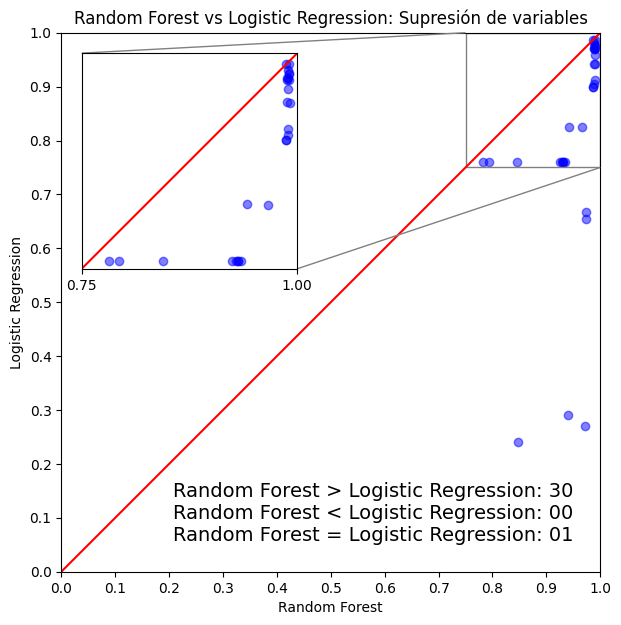

In [119]:
rf_results = np.array([r[1] for r in results])
lr_results = np.array([r[2] for r in results])
plt.scatter(rf_results, lr_results, figure=plt.figure(figsize=(7,7)), c='b', alpha=0.5)
plt.plot(np.linspace(0,1), np.linspace(0,1), 'r')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel("Random Forest")
plt.ylabel("Logistic Regression")

ax = plt.gca()
ax_insert = inset_axes(ax, width="40%", height="40%", loc=2, bbox_to_anchor=(0.025, -0.025, 1, 1),
                      bbox_transform=ax.transAxes)
ax_insert.scatter(rf_results, lr_results, c = 'b', alpha=0.5)
ax_insert.plot(np.linspace(0,1), np.linspace(0,1), 'r')

inicio = 0.75

ticks = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
# ax.axvline(x=0.7, color='gray', linestyle='--')
# ax.axhline(y=0.7, color='gray', linestyle='--')

ax_insert.set_xlim(inicio,1)
ax_insert.set_ylim(inicio,1)
ax_insert.set_xticks([inicio,1])
ax_insert.set_yticks([])
ax.set_xticks(ticks)
ax.set_yticks(ticks)



ax.set_aspect('equal', adjustable='box')
ax_insert.set_aspect('equal', adjustable='box')


mark_inset(ax, ax_insert, loc1=2, loc2=4, fc="none", ec="0.5")
ax.set_title("Random Forest vs Logistic Regression: Supresión de variables")
ax.text(0.95, 0.05,"""Random Forest > Logistic Regression: {:02d}\nRandom Forest < Logistic Regression: {:02d}\nRandom Forest = Logistic Regression: {:02d}""".format(
        sum(rf_results>lr_results),
        sum(rf_results<lr_results),
        sum(rf_results==lr_results),
    ), transform=ax.transAxes, ha='right', va='bottom', fontsize=14)

plt.savefig("rf_vs_lr.png")



plt.show()

Cada punto corresponde a un subconjunto de las variables predictoras. Cómo se ve en el gráfico y en los números de abajo, en 30 de 31 subconjuntos el Random Forest se comporta mejor y en 1 se comporta igual que la Regresión Logistica

In [80]:
print(sum(np.array(rf_results)>np.array(lr_results)))
print(sum(np.array(rf_results)<np.array(lr_results)))
print(sum(np.array(rf_results)==np.array(lr_results)))



30
0
1


Cómo se ve, el random forest domina absolutamente a la regresión líneal simple. Para todo subconjunto de las caracteristicas el random forest tiene una mejor performance.

# Incorporar errores

En la siguiente parte compararemos los modelos pero en vez de deshabilitar algunos sensores ( de una forma que es conocida por los modelos), lo que haremos será intrducir errores en un subconjunto de los sensores (sin que los modelos sepan).

Por tanto, entrenaremos los modelos una unica vez y luego solamente los evaluaremos contra datos modificados. Esto hace esta parte notablemente más rápida

In [31]:
with SuppressPrints():
    random_forest = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.CLASSIFICATION)
    rf_data = tfdf.keras.pd_dataframe_to_tf_dataset(pd.concat([X_train, y_train], axis=1), label="Occupancy")
    random_forest.fit(rf_data)


    logistic = LogisticRegression(len(X_train.columns))
    loss_fn = tf.keras.losses.BinaryCrossentropy()
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)

    logistic.compile(optimizer=optimizer, loss=loss_fn, metrics=['accuracy'])

    epochs = [10, 10, 200]
    batch_size = [32, 128, len(X_train)]
    learning_rate = [0.1, 0.01, 0.001]

    for (ep, bs) in zip(epochs, batch_size):
        logistic.fit(X_train, y_train, epochs=ep, batch_size=bs)

def Informar_con_error(mascara, alfa = 0):
    global random_forest, logistic, X_val, y_val
    
    indices = np.array([(mascara&(2**i)!=0) for i in range(len(X_train.columns))])
    
    X_val_mascara = X_val.copy()
    
    for i in range(len(X_train.columns)):
        if indices[i]:
            X_val_mascara.iloc[:,i] = X_val_mascara.iloc[:,i]*(1-alfa) + alfa*np.random.normal(
                np.mean(X_val_mascara.iloc[:,i]),
                np.std(X_val_mascara.iloc[:,i]), 
                len(X_val_mascara))
    
    y_pred_val = random_forest.predict(tfdf.keras.pd_dataframe_to_tf_dataset(X_val_mascara))
    
    rf_accuracy = accuracy_score(y_val, y_pred_val>0.5)        
    y_pred_val = logistic.predict(X_val_mascara)
    logistic_accuracy = accuracy_score(y_val, y_pred_val>0.5)

    return (X_train.columns, rf_accuracy, logistic_accuracy) 

clear_output()

Al agregar el error,  $X_i$ pasa a ser  $(1-\alpha) * X_i + \alpha * N(promedio(X),desvio\_standar(X))$

In [32]:
alfas = [0.25, 0.5, 0.75, 1]
with SuppressPrints():
    results_error = [[Informar_con_error(i, alfa) for i in range(1, 2**len(X_train.columns))] for alfa in alfas]
clear_output()

Ahora para cada uno de los niveles de error (0.25 a 1) comparamos la performance de ambos modelos. Tenemos graficos adicionales para hacer zoom en la parte donde están todos los puntos y ver el detalle.

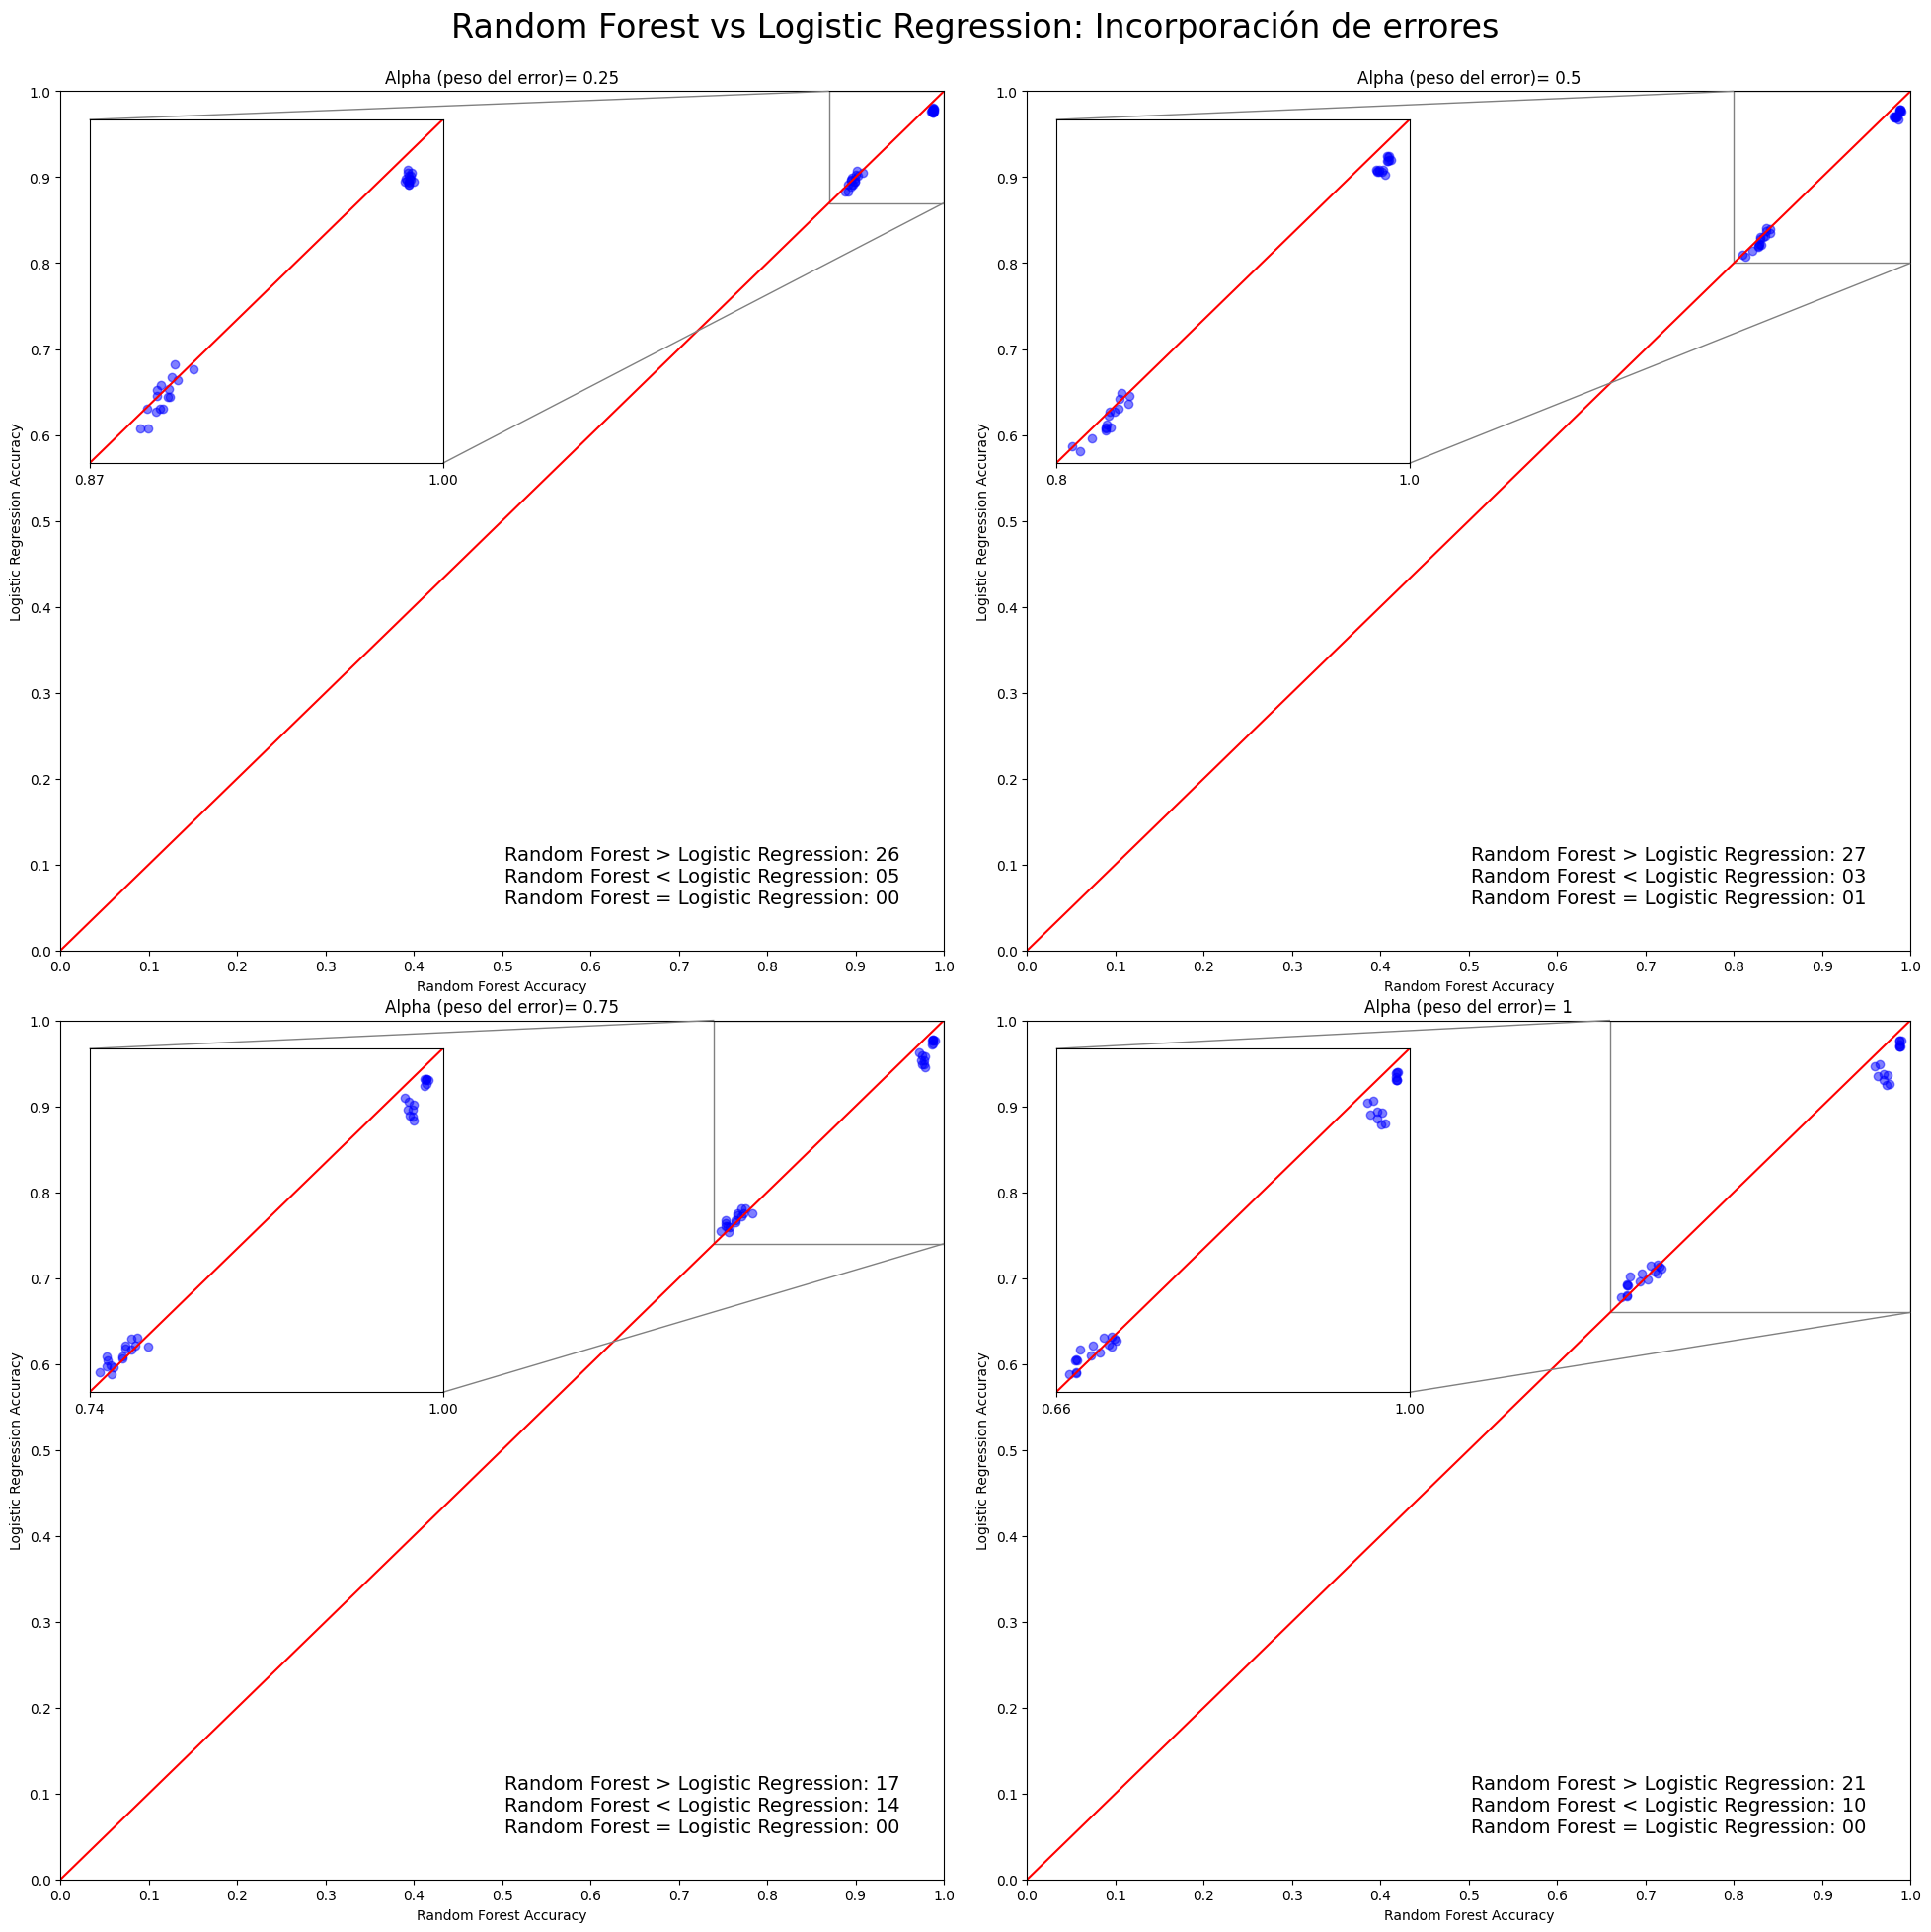

In [117]:
fig, axs = plt.subplots(2,2, figsize=(20,20))
fig.suptitle("Random Forest vs Logistic Regression: Incorporación de errores", fontsize=24)
fig.tight_layout(pad=3.0)
for (i, alfa) in enumerate(alfas):
    ax = axs[i//2, i%2]
    ax.scatter(
        [result[1] for result in results_error[i]],
        [result[2] for result in results_error[i]],
        c = 'b', alpha = 0.5
    )
    ax.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1])
    ax.set_xlim(0,1)
    ax.set_ylim(0,1)
    ax.set_title("Alpha (peso del error)= {}".format(alfa))
    ax.set_xlabel("Random Forest Accuracy")
    ax.set_ylabel("Logistic Regression Accuracy")
    ax.plot([0,1],[0,1], color="red")

    min_acc = round(min([result[1] for result in results_error[i]] + [result[2] for result in results_error[i]]),2) - 0.01

    ax_inset = inset_axes(ax, width="40%", height="40%", loc=2, bbox_to_anchor=(0.025, -0.025, 1, 1), bbox_transform=ax.transAxes)
    ax_inset.set_xlim(min_acc, 1)
    ax_inset.set_ylim(min_acc, 1)
    ax_inset.scatter(
        [result[1] for result in results_error[i]],
        [result[2] for result in results_error[i]],
        c = 'b', alpha = 0.5
    )
    ax_inset.plot([0,1],[0,1], color="red")
    ax_inset.set_xticks([min_acc, 1])
    ax_inset.set_yticks([])
    
    mark_inset(ax, ax_inset, loc1=2, loc2=4, fc="none", ec="0.5")
    ax.text(0.95, 0.05,"""Random Forest > Logistic Regression: {:02d}\nRandom Forest < Logistic Regression: {:02d}\nRandom Forest = Logistic Regression: {:02d}""".format(
        sum(np.array([result[1] for result in results_error[i]])>np.array([result[2] for result in results_error[i]])),
        sum(np.array([result[1] for result in results_error[i]])<np.array([result[2] for result in results_error[i]])),
        sum(np.array([result[1] for result in results_error[i]])==np.array([result[2] for result in results_error[i]]))
    ), transform=ax.transAxes, ha='right', va='bottom', fontsize=14)
    # ax.legend()

plt.savefig("rf_vs_lr_con_error.png")
plt.show()
